Mount google drive containing NASA data

In [1]:
!pip install google
from google.colab import drive
drive.mount('/content/gdrive')
GOOGLEDRIVER_DIR = r'/content/gdrive/My Drive/nasa/'


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Import of libraries

In [0]:

import pandas as pd
import matplotlib.pyplot as plt

import calendar
from datetime import datetime

# Import Facebook's Prophet forecasting library
from fbprophet import Prophet


**Dataset used to predict temperture and level of ocean rising**

In [0]:
#file GMSL.csv(global media of sea level) created with data from the link below:
#https://podaac-tools.jpl.nasa.gov/drive/files/allData/merged_alt/L2/TP_J1_OSTM/global_mean_sea_level
dados_gmsl = pd.read_csv(GOOGLEDRIVER_DIR + r'GMSL.csv',delimiter=',')

#file GLBT.csv(global temperatura) created with data from the link below:
#https://data.giss.nasa.gov/gistemp/
dados_glbt = pd.read_csv(GOOGLEDRIVER_DIR + r'GLB.Ts+dSST.csv',delimiter=',')

#some codes here were based on https://towardsdatascience.com/time-series-analysis-and-climate-change-7bb4371021e

In [4]:
dados_gmsl

,altimeter_type,merged_file_cycle,timestamp,no_obs,no_weighted_obs,GMSL1,stdevGMSL1,smoothed1,GMSL2,stdevGMSL2,smoothed2,smoothed3
0,0,11,1993.011526,466462,337277.00,-37.24,92.66,-37.02,-37.24,92.66,-37.02,-37.55
1,0,11,1993.011526,466462,337277.00,-37.24,92.66,-37.02,-37.24,92.66,-37.02,-37.55
2,0,11,1993.011526,466462,337277.00,-37.24,92.66,-37.02,-37.24,92.66,-37.02,-37.55
3,0,11,1993.011526,466462,337277.00,-37.24,92.66,-37.02,-37.24,92.66,-37.02,-37.55
4,0,12,1993.038692,460889,334037.31,-40.35,95.39,-38.20,-40.34,95.39,-38.19,-38.06
...,...,...,...,...,...,...,...,...,...,...,...,...
1001,0,985,2019.454920,478547,345343.69,46.90,93.86,45.69,54.13,97.01,52.96,57.09
1002,0,986,2019.482086,473862,343775.50,45.68,93.95,45.89,52.89,97.20,53.14,57.01
1003,0,987,2019.509252,470859,342081.69,45.99,94.23,46.03,53.24,97.77,53.28,56.67
1004,0,988,2019.536419,468192,341447.81,47.61,97.02,46.13,54.84,100.57,53.38,56.07


Plot ocean level data from NASA dataset

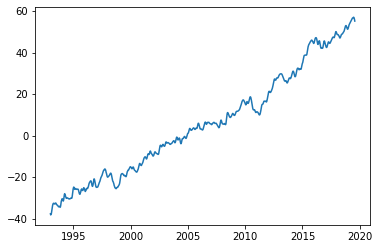

In [5]:
_ = plt.plot(dados_gmsl['timestamp'], dados_gmsl['smoothed3'])

Plot average temperature rise between January and February by year

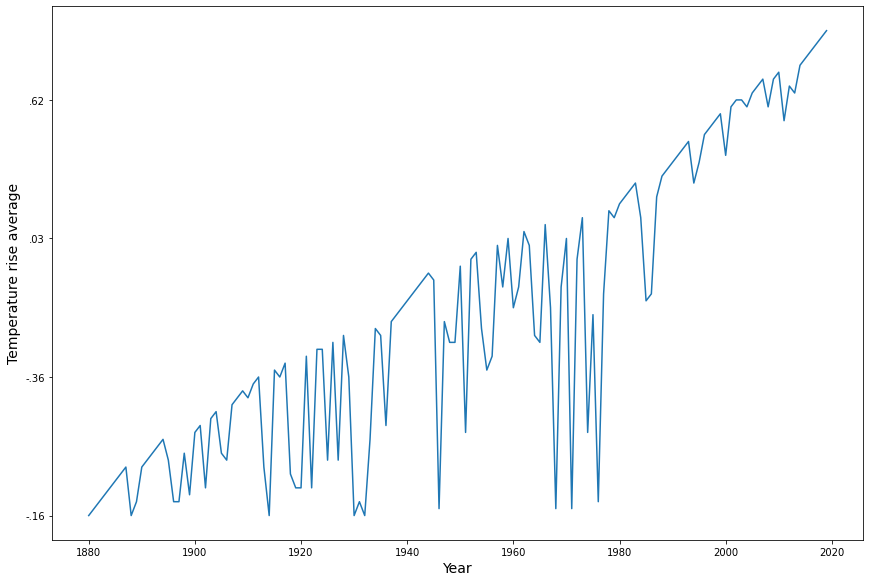

In [6]:
#create subplots
fig,axes = plt.subplots(nrows=1,
                        ncols=1,
                        figsize=(12, 8))
#auto adjust
plt.tight_layout()

#plot and set labels
raw_t = axes.plot(dados_glbt['Year'], 
                  dados_glbt['J-D'])
axes.set_xlabel('Year', fontsize=14)
axes.set_ylabel('Temperature rise average', fontsize=14)

#set the number of ticks
axes.yaxis.set_major_locator(plt.MaxNLocator(4))




Predict 100 years data for Temperature data using fbphrophet

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


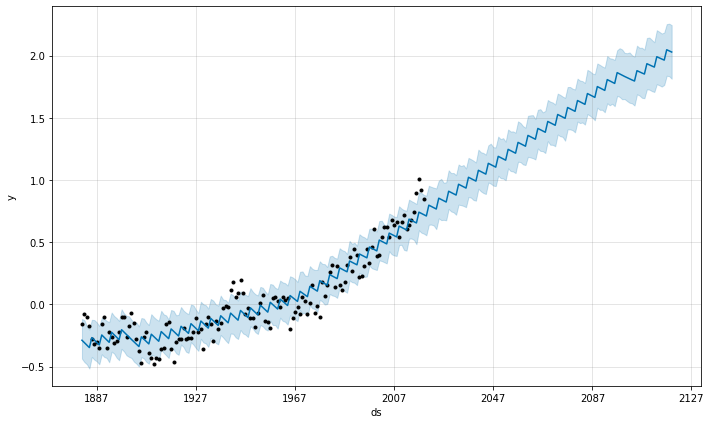

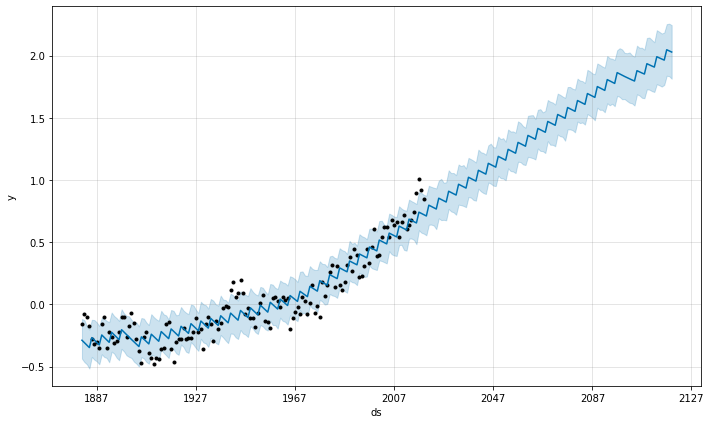

In [8]:
dados_glbt['timestamp'] = pd.to_datetime(dict(year=dados_glbt.Year, 
                                                    month=12, 
                                                    day=31))

#remove 2019 year wich has no value
temperatura_data = dados_glbt[dados_glbt.Year != 2019][['Year', 
                                                        'J-D', 
                                                        'timestamp']]



# Create a new DataFrame with which we will create/train our Prophet model 
t_prophet = pd.DataFrame()
t_prophet['ds'] = temperatura_data.timestamp
t_prophet['y'] = temperatura_data['J-D'].values

# Instantiate model and fit to data (just like with sklearn model API)
m = Prophet()
m.fit(t_prophet)

# Generate future dataframe containing predictions (we are doing this for 100 years into the future)
future = m.make_future_dataframe(freq='A', periods=100)
forecast = m.predict(future)

# Plot the resulting forecast
m.plot(forecast)



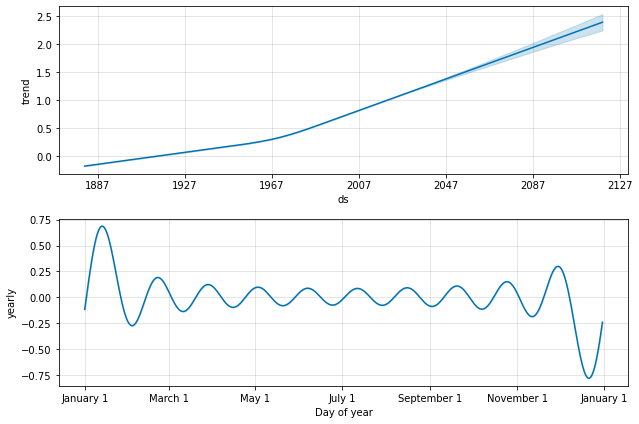

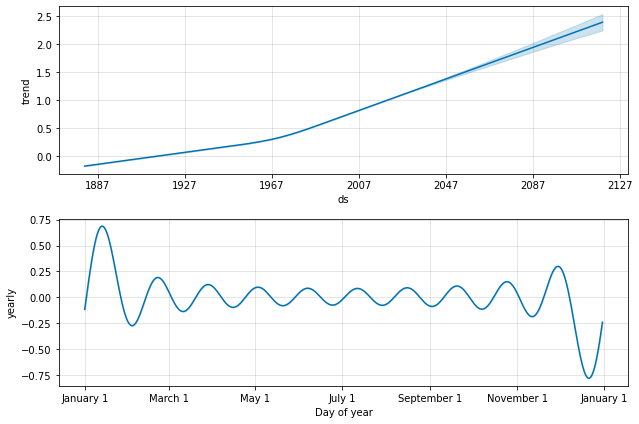

In [9]:
# Plot the forecast components
m.plot_components(forecast)

Prepare ocean level data for prediction

In [0]:
#plt.plot(dados_gmsl['timestamp'], dados_gmsl['smoothed3'])
dados_gmsl[["Year"]] = dados_gmsl[["timestamp"]].fillna(0.0).astype(int)

In [0]:
gmsl_by_year = dados_gmsl.groupby(['Year'])['smoothed3'].max().reset_index()
gmsl_by_year['timestamp'] = pd.to_datetime(dict(year=gmsl_by_year.Year, 
                                                month=12, 
                                                day=31))



Predict ocean level for 100 years

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations. Using 20.


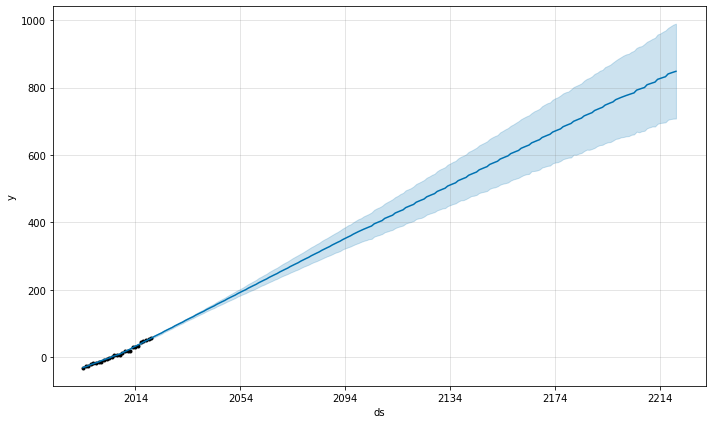

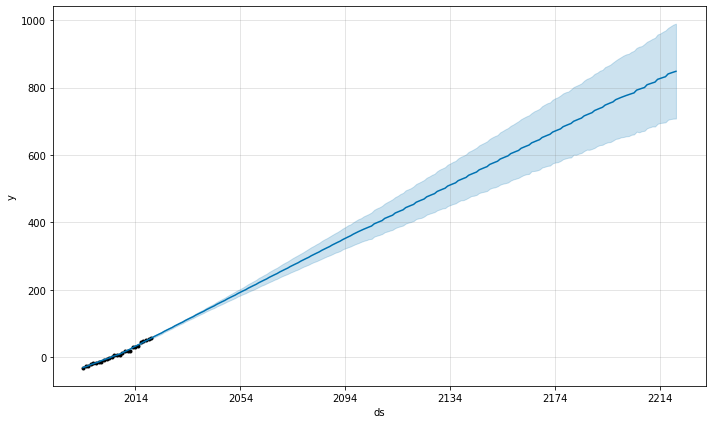

In [12]:
# Create a new DataFrame with which we will create/train our Prophet model 
t_prophet = pd.DataFrame()
t_prophet['ds'] = gmsl_by_year['timestamp'].values
t_prophet['y'] = gmsl_by_year['smoothed3'].values



# Instantiate model and fit to data (just like with sklearn model API)
m = Prophet()
m.fit(t_prophet)

# Generate future dataframe containing predictions (we are doing this for 100 years into the future)
future = m.make_future_dataframe(freq='A', periods=200)
forecast = m.predict(future)

# Plot the resulting forecast
m.plot(forecast)